In [1]:
import json
import networkx as nx

data = json.load(open("/home/vvejalla/centralized-localization/tcas1_cfg_all_functions.json"))

graphs = []

node_to_lines_all = []

for entry in data:
    G = nx.DiGraph()
    node_to_lines = {}
    # edge from line i to line j iff there is a single block with i and j adjacent in the block 
    # or there are two blocks that are connected and 
    # Add nodes and their line mappings
    
    lines_set = set()
    
    
    for node, info in entry["nodes"].items():
        G.add_node(node)
        lines = info.get("lines", [])
        node_to_lines[node] = lines
        lines_set = lines_set.union(set(lines))

    # Add edges
    for edge in entry["edges"]:
        src, tgt = edge
        G.add_edge(src, tgt)
    
    H = nx.DiGraph()
    H.add_nodes_from(lines_set)
    for node in G.nodes:
        for i in range(1, len(node_to_lines[node])):
            H.add_edge(node_to_lines[node][i-1], node_to_lines[node][i])
    
    for edge in G.edges:
        if len(node_to_lines[edge[0]]) > 0 and len(node_to_lines[edge[1]]) > 0:
            H.add_edge(node_to_lines[edge[0]][-1], node_to_lines[edge[1]][0])
    

    graphs.append(H)
    # node_to_lines_all.append(node_to_lines)

In [3]:
import sys
import os

def parse_file(file):
    lookup = {}
    lines = file.readlines()
    for line in lines:
        splitted = line.strip().split(":", 2)
        if len(splitted) < 3:
            continue
        execs, line_no, statement = splitted
        execs = execs.strip()
        line_no = line_no.strip()
        statement = statement.strip()
        execs = execs.strip("*")
        execs = execs.strip()
        
        if not execs.isnumeric():
            continue
        if not line_no.isnumeric():
            raise Exception('weird line number')
        
        execs = int(execs)
        line_no = int(line_no)
        
        if execs <= 0:
            raise Exception('line executed 0 times')
        
        if line_no in lookup:
            raise Exception('repeated line number')
        
        lookup[line_no] = statement
    
    return lookup

passing_dir = "coverage_output/tcas1_passing"
failing_dir = "coverage_output/tcas1_failing"

counts = {}
statement_lookup = {}

total_failed = len(os.listdir(failing_dir))

for i,dir in [(0,passing_dir), (1,failing_dir)]:
    for gcov_file in os.listdir(dir):
        file_name = os.path.join(dir, gcov_file)
        file = open(file_name)
        lookup = parse_file(file)
        file.close()
        
        for line_no in lookup:
            if line_no not in counts:
                counts[line_no] = [0,0]
            
            counts[line_no][i] += 1
            
            if line_no in statement_lookup:
                assert statement_lookup[line_no] == lookup[line_no]
            else:
                statement_lookup[line_no] = lookup[line_no]

print(counts)

{41: [1568, 37], 55: [1568, 37], 65: [1539, 37], 66: [1539, 37], 67: [1539, 37], 68: [1539, 37], 70: [1539, 37], 71: [1539, 37], 72: [1539, 37], 73: [1539, 37], 74: [1539, 37], 75: [1539, 37], 76: [1539, 37], 77: [1539, 37], 78: [1539, 37], 79: [1539, 37], 80: [1539, 37], 81: [1539, 37], 84: [1539, 37], 87: [1539, 37], 90: [1539, 37], 91: [1539, 37], 94: [1539, 37], 97: [788, 37], 98: [1539, 37], 104: [788, 37], 108: [1539, 37], 114: [788, 37], 118: [1539, 37], 119: [1539, 37], 120: [1539, 37], 122: [1539, 37], 124: [1539, 37], 126: [847, 37], 127: [847, 37], 128: [847, 37], 133: [847, 37], 135: [710, 37], 138: [588, 10], 141: [1539, 37], 142: [1539, 37], 95: [751, 0], 100: [751, 0], 110: [751, 0], 134: [137, 0], 136: [122, 27], 57: [29, 0], 58: [29, 0], 59: [29, 0], 60: [29, 0], 61: [29, 0], 62: [29, 0]}


In [4]:
nodes = graphs[0].nodes
mapping = {node: int(node[node.find(":")+1:]) for node in nodes}

In [5]:
mapping

{'tcas1.c:122': 122,
 'tcas1.c:78': 78,
 'tcas1.c:61': 61,
 'tcas1.c:126': 126,
 'tcas1.c:73': 73,
 'tcas1.c:98': 98,
 'tcas1.c:67': 67,
 'tcas1.c:62': 62,
 'tcas1.c:108': 108,
 'tcas1.c:59': 59,
 'tcas1.c:65': 65,
 'tcas1.c:87': 87,
 'tcas1.c:100': 100,
 'tcas1.c:119': 119,
 'tcas1.c:142': 142,
 'tcas1.c:97': 97,
 'tcas1.c:135': 135,
 'tcas1.c:104': 104,
 'tcas1.c:128': 128,
 'tcas1.c:138': 138,
 'tcas1.c:58': 58,
 'tcas1.c:77': 77,
 'tcas1.c:91': 91,
 'tcas1.c:136': 136,
 'tcas1.c:81': 81,
 'tcas1.c:74': 74,
 'tcas1.c:133': 133,
 'tcas1.c:79': 79,
 'tcas1.c:60': 60,
 'tcas1.c:68': 68,
 'tcas1.c:141': 141,
 'tcas1.c:110': 110,
 'tcas1.c:95': 95,
 'tcas1.c:132': 132,
 'tcas1.c:70': 70,
 'tcas1.c:66': 66,
 'tcas1.c:127': 127,
 'tcas1.c:75': 75,
 'tcas1.c:124': 124,
 'tcas1.c:55': 55,
 'tcas1.c:134': 134,
 'tcas1.c:94': 94,
 'tcas1.c:120': 120,
 'tcas1.c:71': 71,
 'tcas1.c:84': 84,
 'tcas1.c:80': 80,
 'tcas1.c:57': 57,
 'tcas1.c:118': 118,
 'tcas1.c:90': 90,
 'tcas1.c:76': 76,
 'tcas1.c:

In [6]:
for i in range(len(graphs)):
    nodes = graphs[i].nodes
    mapping = {node: int(node[node.find(":")+1:]) for node in nodes}
    graphs[i] = nx.relabel_nodes(graphs[i], mapping)

In [7]:
for i in range(len(graphs)):
    for node in graphs[i]:
        if node in counts:
            if counts[node][0] + total_failed - counts[node][1] == 0:
                graphs[i].nodes[node]["score"] = counts[node][1]**2/0.5
            else:
                graphs[i].nodes[node]["score"] = counts[node][1]**2/(counts[node][0] + total_failed - counts[node][1])
            graphs[i].nodes[node]["passing"] = counts[node][0]
            graphs[i].nodes[node]["failing"] = counts[node][1]
        else:
            graphs[i].nodes[node]["score"] = 0
            graphs[i].nodes[node]["passing"] = 0
            graphs[i].nodes[node]["failing"] = 0

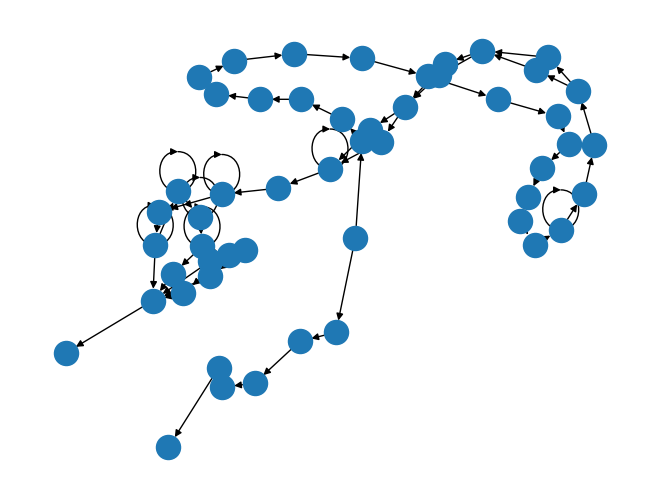

In [8]:
nx.draw(graphs[0])

In [9]:
import numpy as np

In [10]:
def inverse_sqrt_degree_matrix(D):
    d = np.diag(D)
    d_inv_sqrt = np.zeros_like(d)
    nonzero_mask = d > 0
    d_inv_sqrt[nonzero_mask] = 1.0 / np.sqrt(d[nonzero_mask])
    return np.diag(d_inv_sqrt)

In [11]:
graph = graphs[0]


index_to_line = list(graph.nodes)
suspiciousness = [graph.nodes[index_to_line[i]]["score"] for i in range(len(index_to_line))]
line_to_index = {}
for i, line in enumerate(index_to_line):
    line_to_index[line] = i

suspiciousness = np.array(suspiciousness).reshape((-1,1))
adjacency_matrix = np.zeros((len(index_to_line), len(index_to_line)))

for edge in graph.edges:
    adjacency_matrix[line_to_index[edge[0]], line_to_index[edge[1]]] = 1

adj_matrix = adjacency_matrix.copy()

for i in range(adjacency_matrix.shape[0]):
    if adj_matrix[i].sum() == 0:
        adj_matrix[i][i] = 1

adj_matrix/= adj_matrix.sum(axis=1,keepdims=1)

alpha = 0.1
flow = (1-alpha)*suspiciousness + alpha*adj_matrix@suspiciousness

augmented = adjacency_matrix + np.eye(adjacency_matrix.shape[0])
D_in = np.diag(np.sum(augmented, axis=0))
D_out = np.diag(np.sum(augmented, axis=1))

in_suspiciousness = inverse_sqrt_degree_matrix(D_in) @ augmented @ inverse_sqrt_degree_matrix(D_in) @ suspiciousness
out_suspiciousness = inverse_sqrt_degree_matrix(D_out) @ augmented @ inverse_sqrt_degree_matrix(D_out) @ suspiciousness

In [12]:
L1 = suspiciousness.T.tolist()[0]
L1 = [(m,index_to_line[i]) for i,m in enumerate(L1)]
L1.sort(reverse = True)
print(L1)

[(5.5227272727272725, 136), (1.9281690140845071, 135), (1.7373096446700507, 114), (1.7373096446700507, 104), (1.7373096446700507, 97), (1.61629279811098, 133), (1.61629279811098, 128), (1.61629279811098, 127), (1.61629279811098, 126), (0.889538661468486, 142), (0.889538661468486, 141), (0.889538661468486, 124), (0.889538661468486, 122), (0.889538661468486, 120), (0.889538661468486, 119), (0.889538661468486, 118), (0.889538661468486, 108), (0.889538661468486, 98), (0.889538661468486, 94), (0.889538661468486, 91), (0.889538661468486, 90), (0.889538661468486, 87), (0.889538661468486, 84), (0.889538661468486, 81), (0.889538661468486, 80), (0.889538661468486, 79), (0.889538661468486, 78), (0.889538661468486, 77), (0.889538661468486, 76), (0.889538661468486, 75), (0.889538661468486, 74), (0.889538661468486, 73), (0.889538661468486, 72), (0.889538661468486, 71), (0.889538661468486, 70), (0.889538661468486, 68), (0.889538661468486, 67), (0.889538661468486, 66), (0.889538661468486, 65), (0.8730

In [13]:
print(index_to_line[suspiciousness.argmax()])
print(index_to_line[flow.argmax()])
print(index_to_line[out_suspiciousness.argmax()])
print(index_to_line[in_suspiciousness.argmax()])

136
136
136
135


In [ ]:
flow

In [ ]:
suspiciousness

In [ ]:
alpha = 0.1


In [ ]:
suspiciousness